In [1]:
from skykatana import SkyMaskPipe   # the Skykatana code
import healpy as hp, healsparse as hsp, pandas as pd
from mocpy import MOC, WCS
import numpy as np, matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from astropy.coordinates import Angle, SkyCoord
import astropy.units as u
from functools import partial
import lsdb                        # if pixelating source catalogs in HATS format

Excecute the cell below to inject some styles used thougout this notebook

In [9]:
%%html
<style>
.bluepill { background-color:#2196f3;
            color:white; padding:2px 6px;
            border-radius:6px; border:1px solid #ffcc00;
}
.met { background-color:#27333d;
       color:#dedb8e;
       padding:3px 3px; border:1px solid #4e7380;
       border-radius:6px;
}
.sc { font-variant:small-caps; font-weight:bold }
.note { 
    display:inline-block;
    background-color:#175082;
    color:white;
    padding:6px;
    border-radius:6px;
    font-size:1em;
}
.callout {
    border-left: 6px solid #636363;
    border-right: 6px solid #636363;
    border-radius: 6px;
    background: rgba(40,40,40,0.8);  
    padding: 8px 16px;  
    font-size: 1em; 
}
.st {
    color: rgb(255, 255, 255,0.99);
    padding: 0px 8px;
    font-weight: bold;
    border-radius:12px; border:1px solid rgb(247, 94, 94,0.99)
}
.icode {
    font-familiy: monospaced;
    color: rgb(145, 208, 93,0.99);}
</style>

# Creating Star Masks for Rubin in RSP with Skykatana
-----------------
Starting from an input catalog of sources, a list of geometric shapes, or any healsparse map, <span class="sc">Skykatana</span> can create a pixelized mask in healsparse format, excluding areas due to various effects such as bright stars, patches with low depth, extended sources, etc. <span class="sc">Skykatana</span> is also designed to create star masks on-demand in the Rubin Science Platform over thousands of deg<sup>2</sup> in just a few minutes with very limited memory resources, and even intersect masks from different surveys.

Basic usage: 
* <span class="met">build_foot_mask(), build_patch_mask(), build_circle_mask()</span>, etc. are used to produce individual masks <div style="height:0.5em;"></div>
* <span class="met">combine()</span> to merge the maps create above into a "final" mask <div style="height:0.5em;"></div>
* <span class="met">plot()</span> can quickly visualize a mask by plotting randoms, make zooms and overplot stars <div style="height:0.5em;"></div>
* <span class="met">plot_moc</span> to visualize a MOC version of a mask, with accurrate coordinate projections <div style="height:0.5em;"></div>
* <span class="met">makerans</span> to generate randoms over any mask <div style="height:0.5em;"></div>
* <span class="met">apply</span> to cut out sources outside of any given mask

When pixelating an input catalog of sources, <span class="sc">Skykatana</span>  accepts a pandas daframe, any data format readable by astropy, or a HATS catalog. In the latter case, pixelization can be distributed across workers to handle catalogs larger than available memory, such as Rubin.

For creating bright star masks, <span class="sc">Skykatana</span> has special methods to query and pixelate large online catalogs in HATS format (such as Gaia), that work in systems with limited memory resources.

Masks and their metadata are stored as **stages** in a **pipeline** class object that can be saved to disk
<br>
<div class="note">This notebook shows how to produce a mask for Vera Rubin data due to bright stars, by querying Gaia sources on-demand, calculating exclusion radii and pixelating circles. It is meant to be run in the Rubin Science Platform, although it will work anywhere as long as the catalog of stars being queried is available in HATS/LSDB format</div>

## 1. Define search area and create pipeline

<div class='callout'>First we have to define a seach area where to look for stars. While it can be any stage or boolean map, in Rubin it will be most likely some property map for example of coverage in a given band or total exposure time. In the following example, we create a fake search area and store it in the <span class='st'>propmask</span> stage.</div>

In [17]:
# Create the MOC for a rectangular zone in the sky and get its pixels
ord_sparse   = 12
ord_coverage = 5 
moc = MOC.from_zone(SkyCoord([[237, -18], [320, 2]], unit="deg"), max_depth=ord_sparse)
pixels = moc.flatten().astype(np.int64)
# Create empty map and update its pixels
mapbool = hsp.HealSparseMap.make_empty(2**ord_coverage, 2**ord_sparse, dtype=np.bool_)
mapbool.update_values_pix(pixels, True)
# Instantiate the pipline and store in the propmask stage
mkp = SkyMaskPipe(order_out=15)
mkp.propmask = mapbool.as_bit_packed_map()

<div class="callout"> Just type the instance name to display useful information like orders, valid pixels, area, etc.
</div>

In [18]:
mkp

propmask       : (ord/nside)cov=5/32   (ord/nside)sparse=12/4096  valid_pix=7991526  area=1637.51 deg² pix_size=  51.5"

<div class="callout">Lets check how it looks in the sky</div>

Retrieving pixels...
Found 7991526 pixels
Creating display moc from pixels...
MOC max_order is 12 --> degrading to 8...
Drawing plot...


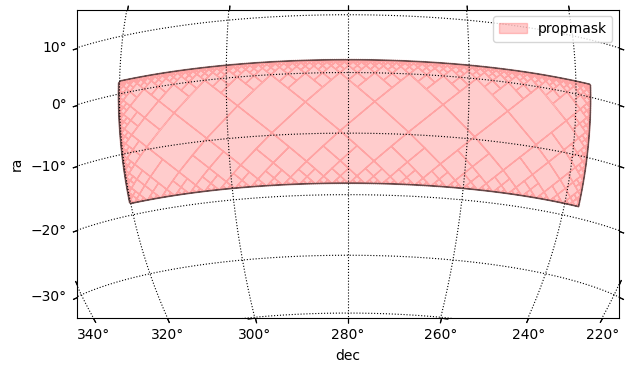

In [27]:
center = SkyCoord(280*u.deg, -15*u.deg)  ;  fov = 50*u.deg
fig, ax, wcs = mkp.plot_moc(stage='propmask', center=center, fov=fov, figsize=[7,4], label='propmask', color='r')
plt.legend();

## 2. Define radius function and star query dictionary

<div class="callout">Now, we define the <span style='font-weight:bold'>radius function</span> that will assign an exclusion radius around the stars. This function, which will passed to SkyKatana, can be completely customized with the only requirement that it must take an input dataframe (e.g. with star magnitudes) and add a "radius" column (in deg) for each row element. In the toy example below, <span class='met'>radfunction()</span> can be customized according to completeness level and desired band.</div>

In [28]:
def radfunction(df: pd.DataFrame, **kwargs):
    mag = 'phot_g_mean_mag'                          # define magnitude to use
    band = kwargs.get('band', 'r')                   # extract band
    completeness = kwargs.get('completeness', 0.85)  # extract completeness level
    if band == 'r':
        if completeness==0.85:
            nconst, alpha = (1234.7,-0.28)  # normalization constant and exponential slope alpha
            magcut        =  17.19          # magnitude cutoff above which stars get a fixed faint_radius
            faintrad      =  10.2           # faint radius [arcsec]
        elif completeness==0.90:
            nconst, alpha = (1318.6,-0.28)  # normalization constant and exponential slope alpha
            magcut        =  17.24          # magnitude cutoff above which stars get a fixed faint_radius
            faintrad      =  10.8           # faint radius [arcsec]
    # Set radius
    df['radius'] = np.where(df[mag] <= magcut, nconst*np.exp(alpha*df[mag])/3600., faintrad/3600.)

<div class='callout'>Now we define the <span style='font-weight:bold'>star query dictionary</span>. This controls where and which stars will be queried, as well as some performance parameters to keep memory usage under control. If the area searched is very large, Skykatana can break it into chunks that are queried, processed and coadded at the end, thus enabling procesing of thousands of deg<sup>2</sup>.</div>

In [29]:
starq = {'search_stage': mkp.propmask,                 # The stage where we want to retrieve stars
         'cat':"https://data.lsdb.io/hats/gaia_dr3",   # URL of HATS catalog, e.g. for Gaia
         'columns':['ra','dec','phot_g_mean_mag'],     # Columns to retrieve from it
         'gaia_gmag_lims':[7,20],                      # G_band magnitude limits
         'radfunction': partial(radfunction, completeness=0.85, band='r'),  # Star radius function. Must be wrapped with partial()
         'avoid_mw': True,                             # Avoid Milky Way plane & bulge
         'b0_deg': 15.,                                # Mikly Way plane zone of exclusion from -b to b (deg)
         'bulge_a_deg': 25.,                           # Milky Way bulge semimajor axis length (deg)  
         'bulge_b_deg': 20.,                           # Milky Way bulge semiminor axis length (deg)
         'max_area_single': 700.,                         # Optional - max area to make in a single query
         'target_chunk_area': 700.,                       # Optional - target area of chunks that the search_stage is splitted into
         'coarse_order_bfs': 5                            # Optional - coarse order to perform chunking
         }

<div class='callout'>Large-scale queries might accidentally go deep into the Milky Way plane and bulge, stressing database systems and leading memory issues or failed searches. To prevent this, when <span class='icode'>avoid_mw=True</span> SkyKatana will create a MOC map of the galaxy following the given parameters for the plane and (elliptical) bulge, and subtract if <span style='font-weight:bold'>before</span> searching for stars. In addition, that galaxy mask will get stored in the <span class='st'>mwmask</span> in case you need to combine it with other stages.</div>

<div class="note">Note that the stars returned will always follow the search stage minus the galaxy mask, if chosen so, but the search stage in the pipeline remains untouched. Subtract <span class='st'>mwmask</span> from that or any other stage, when needed.</div>

## 3. Search stars, construct its mask and plot

<div class='callout'>We have everything ready. Just choose the orders for pixelization and run</div>

In [ ]:
mkp.build_star_mask_online(starq=starq, order_star=15, order_cov=5, n_threads=1);

## 4. Build methods: from geometry to masks

<div class="callout"><span class="sc">Skykatana</span> has methods to pixelate and generate masks from a variety of geometric shapes</div>

In [ ]:
mkp = SkyMaskPipe(order_out=15)
mkp.build_foot_mask(sources=lsdb.open_catalog(HATSCAT), mapping=False);       # from individual point sources
mkp.build_prop_mask(prop_maps=PROPMAP_FILE,thresholds=1.3,comparisons='lt');  # from healsparse property maps
mkp.build_circ_mask(data=STARS_REGIONS, fmt='parquet');                       # from circular regions
mkp.build_box_mask(data=BOX_STARS_REGIONS, fmt='parquet');                    # from box regions
mkp.build_ellip_mask(data=ELLIP_REGIONS, fmt='ascii');                        # from elliptical regions
mkp.build_poly_mask(data=USER_POLY_REGIONS, fmt='ascii');                     # from quadrangular sky polygons
mkp.build_zone_mask(data=USER_ZONE_REGIONS, fmt='ascii');                     # from zones delimited by ra-dec boundaries
mkp.build_patch_mask(patchfile=PATCH_FILE, qafile=QA_FILE);                   # from a sets of patches with custom filtering

<div class="callout">Each the these <span style='font-family: monospace; font-weight:bold;'>build_</span> methods store its calling arguments in dictionaries under <span style='font-family: monospace;font-weight:bold;'>_params</span>. In this way, all the metadata used to create masks is saved in the pipeline and kept for record</div>

In [9]:
mkp._params['footmask']

{'sources': '../../skykatana_example_data/example_data/hscx_minispring_gal',
 'order_foot': 13,
 'order_cov': 4,
 'columns': ('ra', 'dec'),
 'remove_isopixels': False,
 'erode_borders': False,
 'bit_packing': True,
 'pixels': np.int64(1353948),
 'area_deg2': np.float64(69.35790724770318)}

<div class="callout">All <span style='font-family: monospace; font-weight:bold;'>build_</span> methods create a stage of a given name, e.g. <span class='st'>footmask</span>, <span class='st'>propmask</span>, <span class='st'>circmask</span>, etc. But you can add your own stages with any name or origin as long as they are healsparse boolean masks</div>

<div class='note'>Note that while any name is valid for a stage, only stages ending with "mask" show up when printing, e.g cirrusmask, satellitemask, nebulamask</div>

In [ ]:
# Create a bogus cirrus mask and add it to the pipeline
import healsparse as hsp, numpy as np
from mocpy import MOC
from astropy.coordinates import SkyCoord
moc = MOC.from_zone(SkyCoord([[220, -5], [222, 0.3]], unit="deg"), max_depth=15)
cirrus = hsp.HealSparseMap.make_empty(2**4, 2**15, dtype=np.bool_)
pixels = moc.flatten().astype(np.int64)
cirrus.update_values_pix(pixels, True)
cirrusmask = cirrus.as_bit_packed_map()

mkp.cirrusmask = cirrusmask

<br>
<div class="callout">Then you can work, combine and plot as with any other stage</div>

In [ ]:
mkp.combine(positive=['footmask','patchmask','cirrusmask'], negative=['circmask','boxmask','ellipmask']);

**Skykatana has methods to create custom bright star masks over any stage or healsparse map. The code can query large HATS catalog on-demand such as GAIA, add star radii with user-defined functions, pixelize the corresponding circles, and return a healsparse mask. It is also highly adapted to run in the Rubin Science Plataform (RSP) and low memory environments**

-------------------
**STEP 1 : define star radius function and query dictionary**

In [ ]:
from functools import partial

# This function determines the radius of stars that will be masked. It can be completely customized according to band, 
# completeness level, or any other parameter. The only requirement is that it must take an input df (e.g. with 
# star magnitudes) and add a "radius" column (in deg)

def radfunction(df: pd.DataFrame, **kwargs):
    mag = 'phot_g_mean_mag'                          # define magnitude to use
    band = kwargs.get('band', 'r')                   # extract band
    completeness = kwargs.get('completeness', 0.85)  # extract completeness level
    if band == 'r':
        if completeness==0.85:
            nconst, alpha = (7538.,-0.38)  # normalization constant and exponential slope alpha
            magcut        =  17.           # magnitude cutoff above which stars get a fixed faint_radius
            faintrad      =  11.8          # faint radius [arcsec]
        elif completeness==0.80:
            pass
    # Set radius
    df['radius'] = np.where(df[mag] <= magcut, nconst*np.exp(alpha*df[mag])/3600., faintrad/3600.)

# Star query dictionary. This controls where and which stars will be queried, as well as some performance
# parameters to keep memory usage under control. If the area searched is very large, Skykatana can break
# it into chunks that are queried, processed and coadded at the end, enabling procesing of thousands of sq degrees

starq = {'search_stage': mkp.mask,                       # The stage where we want to retrieve stars
         'cat':"https://data.lsdb.io/hats/gaia_dr3",     # URL of HATS catalog, e.g. for Gaia
         'columns':['ra','dec','phot_g_mean_mag','b'],   # Columns to retrieve from it
         'gaia_gmag_lims':[7,19],                        # G_band magnitude limits
         'gaia_b_lims':[-20,20],                         # Galactic latitude range to exclude the MW disk
         'radfunction': partial(radfunction, completeness=0.85, band='r'),  # Star radius function. Must be wrapped with partial()
         'max_area_single': 1000.,                       # Optional - max area to make in a single query
         'target_chunk_area': 1000.,                     # Optional - target area of chuncks that the search_stage is splitted
         'coarse_order_bfs': 5                           # Optional - coarse order to perform chunking
         }

-------------------
**STEP 2 : set up a dask client**

In [ ]:
from dask.distributed import Client
client = Client(n_workers=2, threads_per_worker=1, memory_limit="8GiB")

-------------------
**STEP 3 : get stars and build the mask**

In [ ]:
mkp.build_star_mask_online(starq=starq)

<br>

**Now we have a new starmask stage !**

In [27]:
mkp

footmask       : (ord/nside)cov=4/16   (ord/nside)sparse=13/8192  valid_pix=1353948  area= 69.36 deg² pix_size=  25.8"
patchmask      : (ord/nside)cov=4/16   (ord/nside)sparse=13/8192  valid_pix=1062650  area= 54.44 deg² pix_size=  25.8"
circmask       : (ord/nside)cov=4/16   (ord/nside)sparse=15/32768 valid_pix=3834656  area= 12.28 deg² pix_size=   6.4"
boxmask        : (ord/nside)cov=4/16   (ord/nside)sparse=15/32768 valid_pix=1737887  area=  5.56 deg² pix_size=   6.4"
ellipmask      : (ord/nside)cov=4/16   (ord/nside)sparse=15/32768 valid_pix=169105   area=  0.54 deg² pix_size=   6.4"